Владислав, привет

Я пока что не могу полностью писать и продумывать всё сама, поэтому делаю по аналогии

Сделала пока не все этапы, но потихоньку стараюсь разобраться

1) Проверка данных (сделано)
2) Разделить данные для тренировки и тестирования машины (да)
3) Переработать данные для адекватного входа для алгоритма


In [2]:
%pip install matplotlib
%pip install numpy
import matplotlib as plt
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\1\appdata\local\programs\python\python311\lib\site-packages (1.26.0)



In [3]:
df = pd.read_csv("datasets\insurance.csv")
# возраст: возраст основного получателя
# пол: страховой агент пол, женщина, мужчина
# ИМТ: индекс массы тела, позволяющий получить представление о телосложении, относительно высоком или низком весе по отношению к росту, объективный индекс массы тела (кг / м2) с использованием отношения роста к весу, в идеале от 18,5 до 24,9
# дети: количество детей, охваченных медицинской страховкой / Количество иждивенцев
# курильщик
# регион: район проживания получателя в США, северо-восток, юго-восток, юго-запад, северо-запад.
# расходы: Индивидуальные медицинские расходы, оплачиваемые медицинской страховкой
# Требуется прогнозировать колонку charges.

'''
гипотезы

чем меньше возраст, тем больше траты на медобслуживание (люди получают права и начинают чаще попадать в аварии)
чем больше вес, тем больше траты (более вероятны проблемы со здоровьем, если коэффициент выходит за 25)
чем больше детей, тем больше траты (выше вероятность что мелкенький попадёт в неприятность - сломает ногу или под машину)
'''

df.head()
true_charges = df["charges"]

<Axes: xlabel='age'>

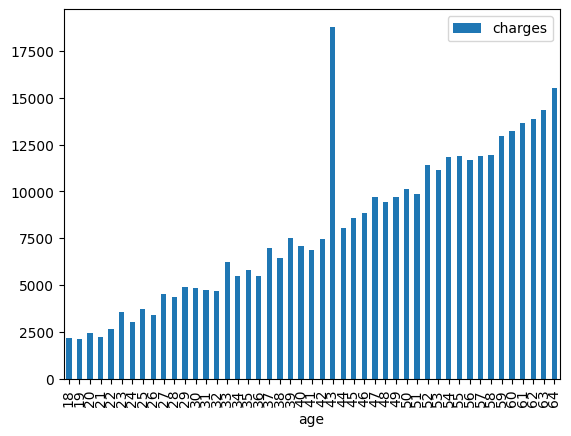

In [5]:
df.groupby(["age"]).agg({"charges": "median", "age": "min"}).plot(x="age", kind="bar")

<Axes: >

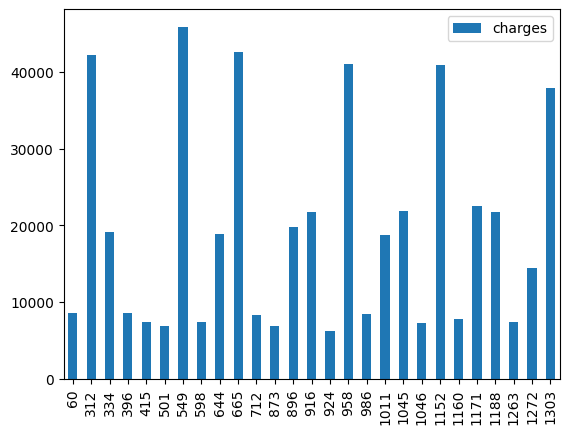

In [6]:
#хотела узнать, почему аномалия на возрасте 43, вроде всё в порядке
#снизу индексы
age43 = df[df["age"] == 43]
age43.plot(y="charges", kind = "bar")

# хочу узнать количество строк в каждой группе
# df_age = df.groupby(["age"])
# df_age["charges"].count()

<Axes: xlabel='sex'>

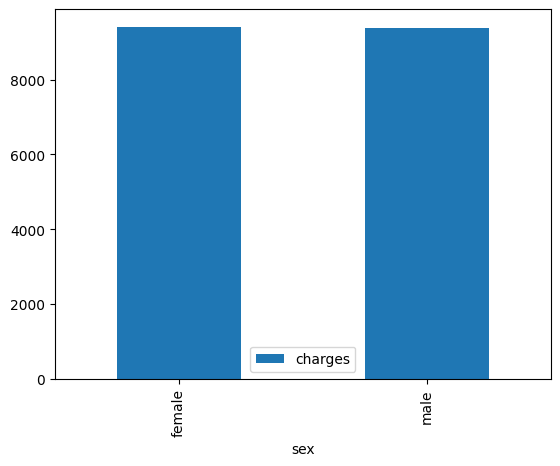

In [7]:
df.groupby(["sex"]).agg({"charges": "median", "sex": "min"}).plot(x="sex", kind="bar")


<Axes: xlabel='bmi'>

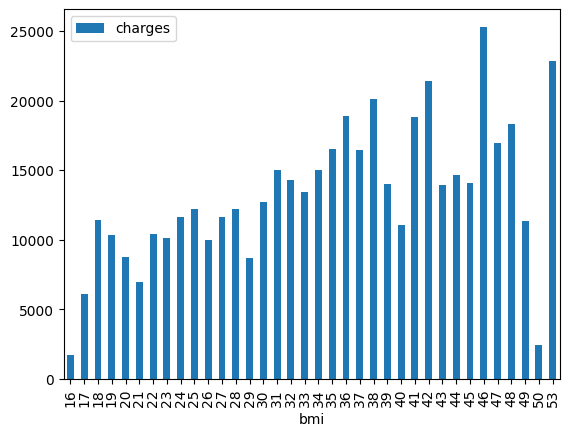

In [8]:
df["bmi"] = df["bmi"].apply(lambda x: round(x))
df.groupby(df["bmi"]).agg({"charges": "mean", "bmi": "max"}).plot(x="bmi", kind="bar")
#будто есть тренд, чем больше bmi, тем больше страховка, но он странно проваливается иногда
#хотя суммарно выдерживается

In [9]:
bmi50 = df[df["bmi"] == 50]
bmi50
#в bmi50 просто попал только один человек, поэтому там провал в данных

,age,sex,bmi,children,smoker,region,charges
847,23,male,50,1,no,southeast,2438.0552


<Axes: xlabel='children'>

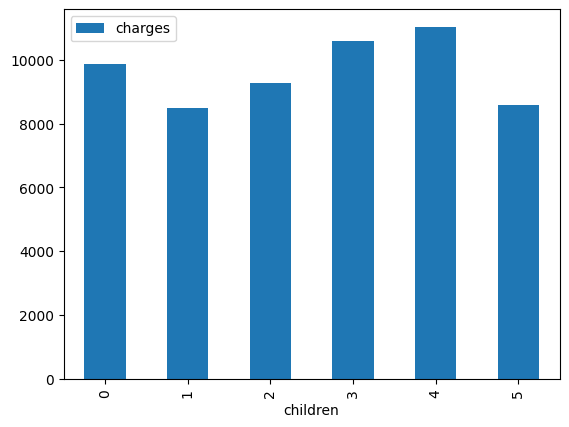

In [10]:
df.groupby(["children"]).agg({"charges": "median", "children": "min"}).plot(x="children", kind="bar")
#непонятно, есть ли зависимость

<Axes: xlabel='smoker'>

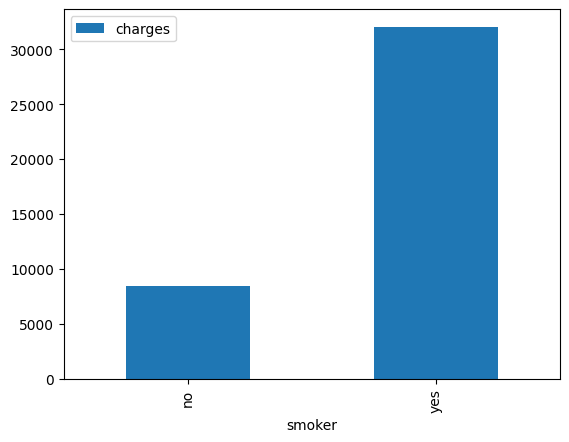

In [11]:
df.groupby(["smoker"]).agg({"charges": "mean", "smoker": "min"}).plot(x="smoker", kind="bar")
#тут всё очевидно

<Axes: xlabel='region'>

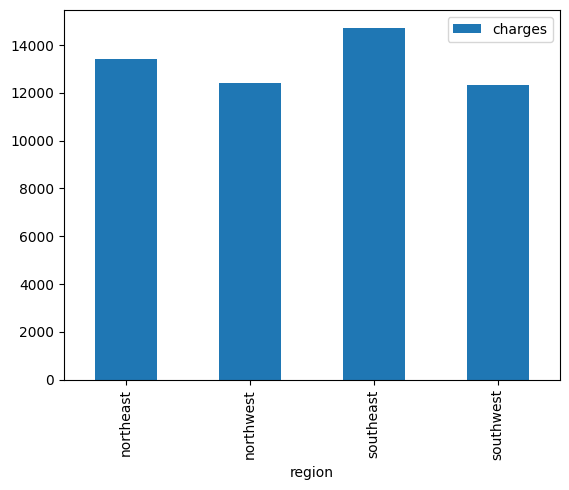

In [12]:
df.groupby(["region"]).agg({"charges": "mean", "region": "min"}).plot(x="region", kind="bar")

In [13]:
data = df[["age", "sex", "children", "smoker", "region", "charges"]]

data_x = data.drop(["charges"], axis = 1)
data_y = data.charges

In [22]:
#посчитала, насколько charges отличается от медианы, но наверно можно было и без этого
#я решила заменить ручками так, чтобы charges либо больше 1, либо меньше, потому что там функция
#не хотела принимать floats

med_charges = df["charges"].median() #median charges
#9382.033

#мне нужно все, которые больше медчар заменить на 1, а все, которые меньше, заменить на 0

df1 = df[df["charges"]<=med_charges]
df1["charges"] = 0
df2 = df[df["charges"]>med_charges]
df2["charges"] = 1

frames = [df1, df2]
df3 = pd.concat(frames)
df["charges"] = df3["charges"]
# df["charges_binary"] = df["charges"].agg({"charges": t})

C:\Users\1\AppData\Local\Temp\ipykernel_3456\2408730073.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["charges"] = 0
C:\Users\1\AppData\Local\Temp\ipykernel_3456\2408730073.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["charges"] = 1


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
                    (OneHotEncoder(), ["sex", "smoker", "region"]),
                    remainder="passthrough"
                    )

transformer.fit(data_x)

#а что вообще фит делает, если мы в него засунули только 1 пакет данных?
#а почему мы специально трансформер делали, если нам нужно только 1 раз наши данные перевести?

# onehotencoder работает только для категориальных признаков, это smoker и region
# можно children (потому что значения от 0 до 5)


ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['sex', 'smoker', 'region'])])

In [15]:
def transform_preproc(data, transformer):
    res = transformer.transform(data)
    res = pd.DataFrame(
        res,
        columns=transformer.get_feature_names_out()
    )
    return res

#copy it till you make it 😎
#получается, эта штука сначала трансформирует, 
#поскольку traintestsplit'у нужны какие-то features, мы их создаём названиями колонок

In [16]:
from sklearn.model_selection import train_test_split

data_x_df = transform_preproc(data_x, transformer) #data_y, train_size=0.2

train_x, test_x, train_y , test_y = train_test_split (data_x_df, data_y, train_size = 0.2, random_state = 5)
#random_state - same value, same split

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values
    # for a given model. 

dt = DecisionTreeClassifier()
dt.fit(train_x, train_y)

# Ошибка: Unknown label type: continuous.
# Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.